## Demonstrate geometric properties before and after processing

In [1]:
import pandas as pd
import numpy as np
import cupy as cp
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelWithLMHead
from transformers import *
import torch
import math

In [2]:
model_name = 'bert-base-uncased'
if model_name == 'bert-base-uncased':
    emb_type = 'base'
if model_name == 'bert-large-uncased':
    emb_type = 'large'
    
# list ds for testing
D = [1,2,3]

In [3]:
def draw_singular_value(singular_values):
    plt.figure(figsize = (8,6))
    plt.plot(singular_values,c = 'darkblue')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('index', fontsize=16)
    plt.ylabel('singular value', fontsize=16)
    plt.legend(fontsize=16)


In [4]:
def draw_logscatter(c1,c2,E,components,count):
    x = np.inner(E,components[c1-1])
    y = np.inner(E,components[c2-1])
    count_log = [math.log(c) if not c == 0 else 0 for c in count ]
    plt.figure(figsize=(8,6))
    plt.scatter(x, y, c = count_log, alpha = 0.3, s=10)
    plt.colorbar()

In [5]:
def scatter_across_freq(count,data, data_name):

    plt.figure(figsize = (8,6))
    plt.scatter(count, data, alpha = 0.3, s = 10, c = 'royalblue')

    plt.xscale('log')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('word count', fontsize=16)
    plt.ylabel(data_name, fontsize=16)
    

In [6]:
def get_avg_cosine(emb_cpu):
    emb_gpu = cp.array(emb_cpu)
    cosine_avg = []
    for i in range(emb_gpu.shape[0]):
        inner_i = cp.inner(emb_gpu,emb_gpu[i].T)
        avg_i = cp.sum(inner_i)/emb_gpu.shape[0]
        cosine_avg.append(avg_i)
        if i%50000 == 0:
            print('%dth done' % i)
    
    return cosine_avg

In [7]:
bert_model = BertModel.from_pretrained(model_name)
bert_model.eval()
bert_tokenizer = BertTokenizer.from_pretrained(model_name)
embedding = bert_model.get_input_embeddings()

ids = torch.tensor(range(30522))
E = embedding(ids).detach().numpy()
print('BERT Embedding shape check:', E.shape)

BERT Embedding shape check: (30522, 768)


# original embedding

No handles with labels found to put in legend.


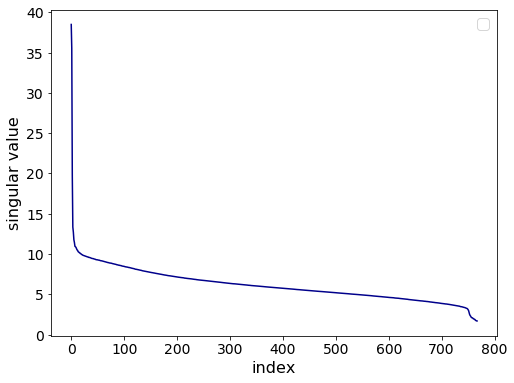

In [8]:
pca = PCA().fit(E)
draw_singular_value(pca.singular_values_)

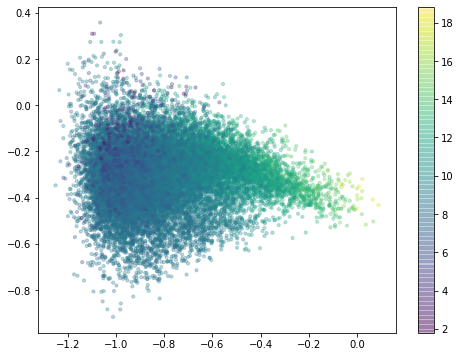

In [9]:
# load word frequency data
word_freq_vocab = pd.read_csv('datasets\ordered_vocab.csv')
E_freq = embedding(torch.tensor(word_freq_vocab['index'])).detach().numpy()
pca = PCA().fit(E_freq)
draw_logscatter(1,2,E_freq,pca.components_,word_freq_vocab['count'])

In [10]:
vec_norm = np.linalg.norm(E_freq, axis = 1)
norm = np.tile(vec_norm,(E_freq.shape[1],1))
print(norm.shape)
E_freq_norm = E_freq/norm.T
print(E_freq_norm.shape)

cos_avg = np.array(get_avg_cosine(E_freq_norm))

(768, 21722)
(21722, 768)
0th done


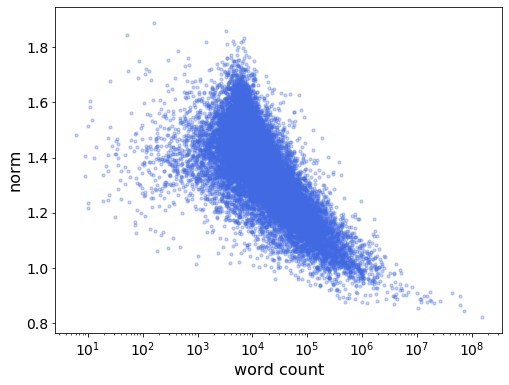

In [11]:
scatter_across_freq(word_freq_vocab['count'],vec_norm, 'norm')

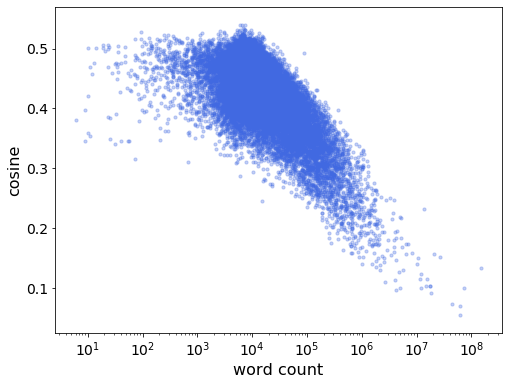

In [12]:
cos_avg = np.array(cos_avg)
scatter_across_freq(word_freq_vocab['count'], cos_avg, 'cosine')

# WR-processed embedding

In [13]:
d = 5
wr_emb = np.load('trained-embedding/%sEmb_%s.npy' % (emb_type, d))

No handles with labels found to put in legend.


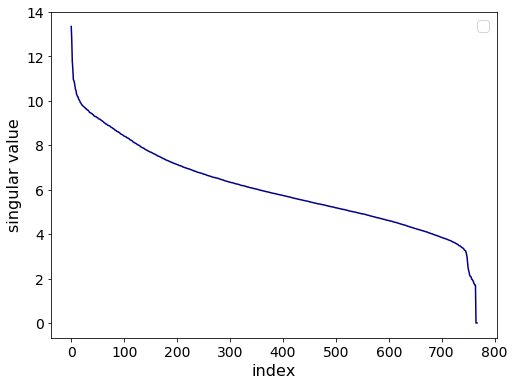

In [14]:
pca = PCA().fit(wr_emb)
draw_singular_value(pca.singular_values_)

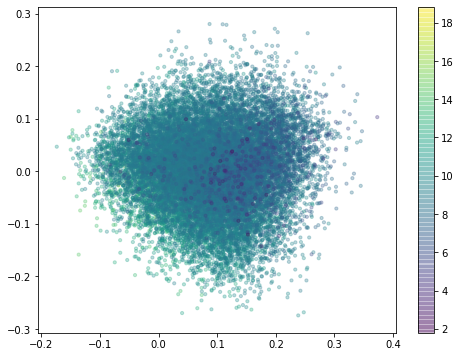

In [15]:
E_freq = wr_emb[word_freq_vocab['index']]
pca = PCA().fit(E_freq)
draw_logscatter(1,2,E_freq,pca.components_,word_freq_vocab['count'])

In [16]:
vec_norm = np.linalg.norm(E_freq, axis = 1)
norm = np.tile(vec_norm,(E_freq.shape[1],1))
print(norm.shape)
E_freq_norm = E_freq/norm.T
print(E_freq_norm.shape)

cos_avg = np.array(get_avg_cosine(E_freq_norm))

(768, 21722)
(21722, 768)
0th done


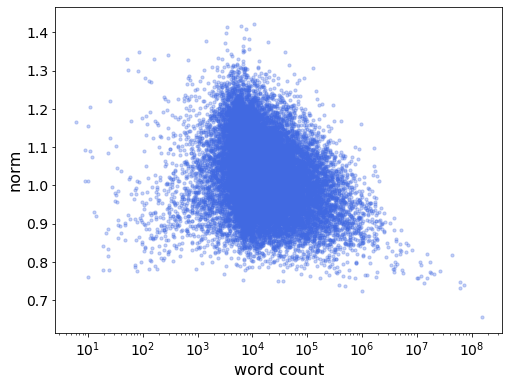

In [17]:
scatter_across_freq(word_freq_vocab['count'],vec_norm, 'norm')

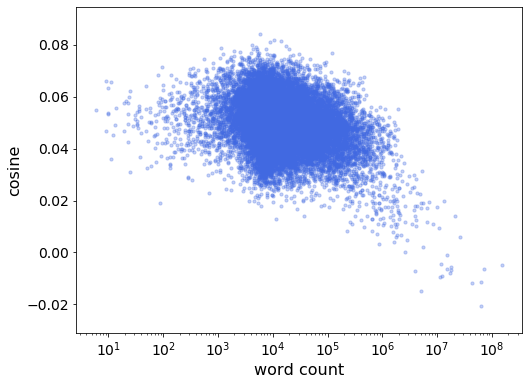

In [18]:
cos_avg = np.array(cos_avg)
scatter_across_freq(word_freq_vocab['count'], cos_avg, 'cosine')